In [14]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

%run ../src/utility.py

np.random.seed(1231)

```
In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

```

In [2]:
# load files

# age_gender_bkts = pd.read_csv('../data/age_gender_bkts.csv')
# countries       = pd.read_csv('../data/countries.csv')
train           = pd.read_csv('../data/train_users_2.csv', parse_dates=[1, 3])
test            = pd.read_csv('../data/test_users.csv', parse_dates=[1, 3])
# sub             = pd.read_csv('../data/sample_submission_NDF.csv')

` country_destination is the target variable `

In [17]:
count_missing_values(train)

{'affiliate_channel': 0,
 'affiliate_provider': 0,
 'age': 87990,
 'country_destination': 0,
 'date_account_created': 0,
 'date_first_booking': 124543,
 'first_affiliate_tracked': 6065,
 'first_browser': 0,
 'first_device_type': 0,
 'gender': 0,
 'id': 0,
 'language': 0,
 'signup_app': 0,
 'signup_flow': 0,
 'signup_method': 0,
 'timestamp_first_active': 0}

In [18]:
count_missing_values(test)

{'affiliate_channel': 0,
 'affiliate_provider': 0,
 'age': 28876,
 'date_account_created': 0,
 'date_first_booking': 62096,
 'first_affiliate_tracked': 20,
 'first_browser': 0,
 'first_device_type': 0,
 'gender': 0,
 'id': 0,
 'language': 0,
 'signup_app': 0,
 'signup_flow': 0,
 'signup_method': 0,
 'timestamp_first_active': 0}

** Age, Date of first booking and First Affiliate Tracked have missing values **

In [3]:
# concat train and test

ntrain = len(train)
data   = pd.concat((train, test))
target = train.country_destination

In [4]:
data = data.drop(labels='country_destination', axis=1)
del train, test

In [5]:
# list of features captured
data.columns

Index(['affiliate_channel', 'affiliate_provider', 'age',
       'date_account_created', 'date_first_booking', 'first_affiliate_tracked',
       'first_browser', 'first_device_type', 'gender', 'id', 'language',
       'signup_app', 'signup_flow', 'signup_method', 'timestamp_first_active'],
      dtype='object')

** Let's look at affliate channel: What kind of paid marketing ? **

In [6]:
# categorical variable
print('Feature type: %s'%(data.affiliate_channel.dtype))

Feature type: object


In [7]:
data.affiliate_channel.value_counts()

direct           181571
sem-brand         36439
sem-non-brand     20075
seo               14362
other              9547
api                8167
content            4118
remarketing        1268
Name: affiliate_channel, dtype: int64

In [8]:
# is there any relationship between target and this feature
affiliate_channel_rel = pd.crosstab(data.iloc[:ntrain]['affiliate_channel'],  target)

In [9]:
affiliate_channel_rel

country_destination,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
affiliate_channel,,,,,,,,,,,,
api,17,30,22,56,87,60,50,5382,20,1,2124,318
content,7,17,5,26,57,7,21,3390,8,1,327,82
direct,363,945,699,1536,3294,1579,1858,78329,503,144,41725,6752
other,10,70,35,34,115,44,63,5361,12,8,2969,240
remarketing,1,7,5,21,35,13,17,728,2,1,225,41
sem-brand,65,154,137,278,669,329,463,14951,103,37,7725,1134
sem-non-brand,59,147,112,180,533,193,242,11694,80,17,4552,1035
seo,17,58,46,118,233,99,121,4708,34,8,2729,492


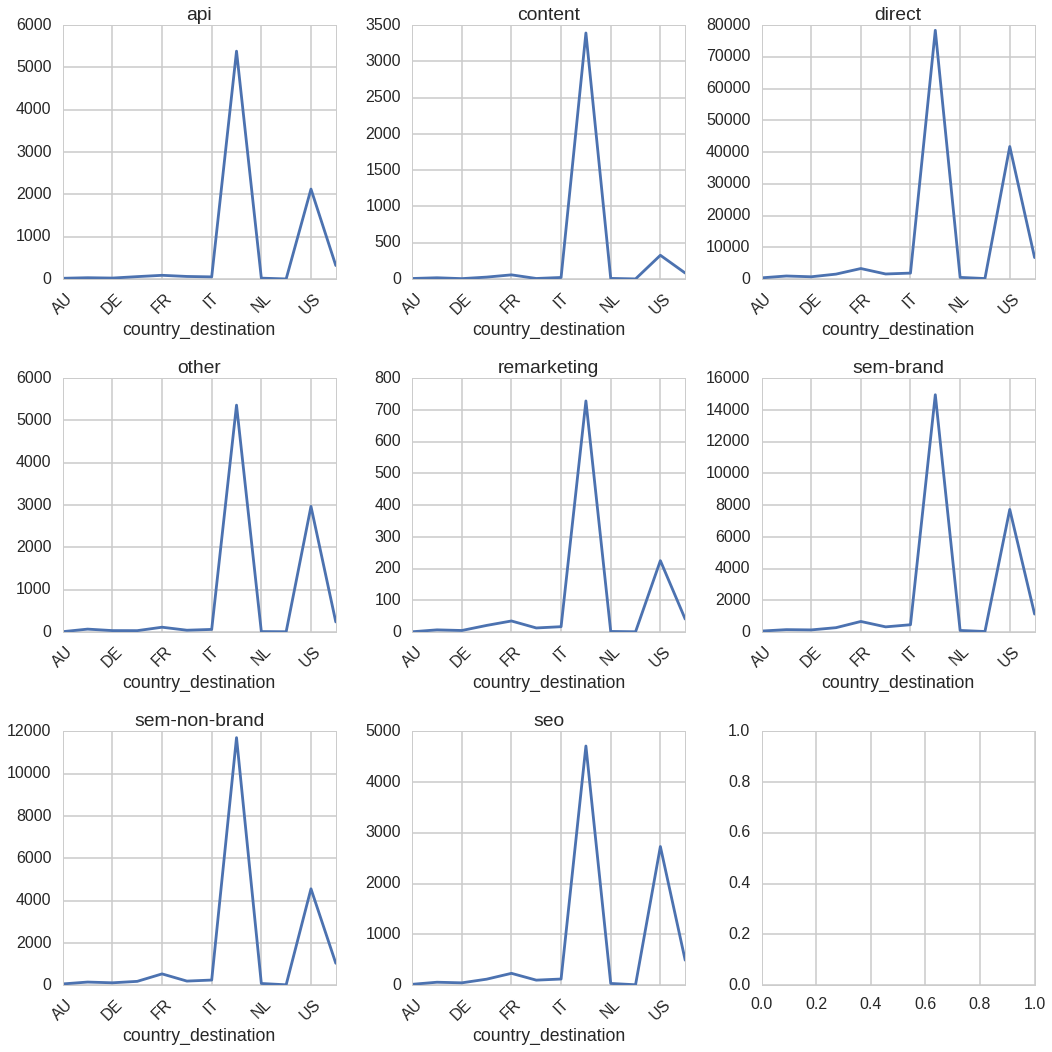

In [15]:
plot_crosstab_distribution(affiliate_channel_rel)

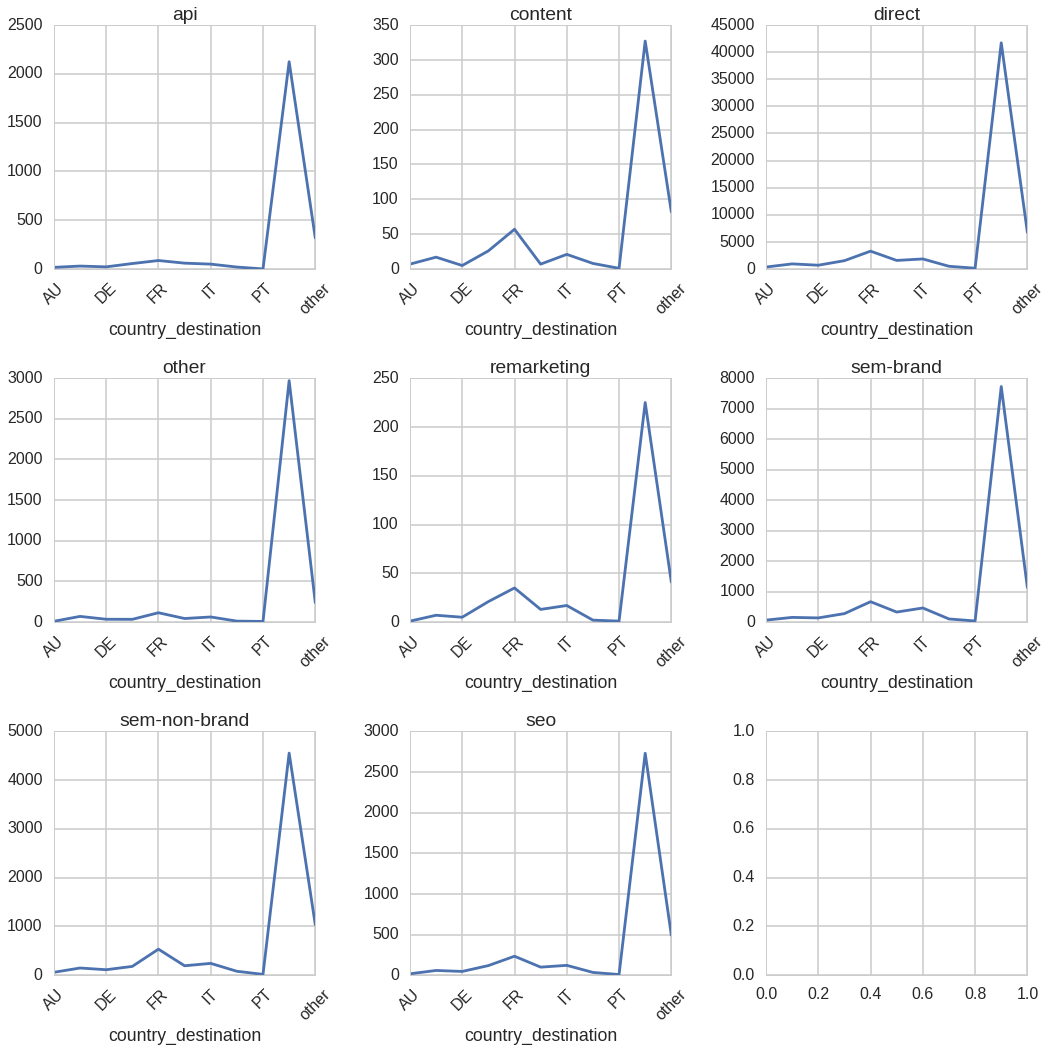

In [125]:
# exclude NDF
plot_crosstab_distribution(affiliate_channel_rel[affiliate_channel_rel.columns.drop('NDF')])

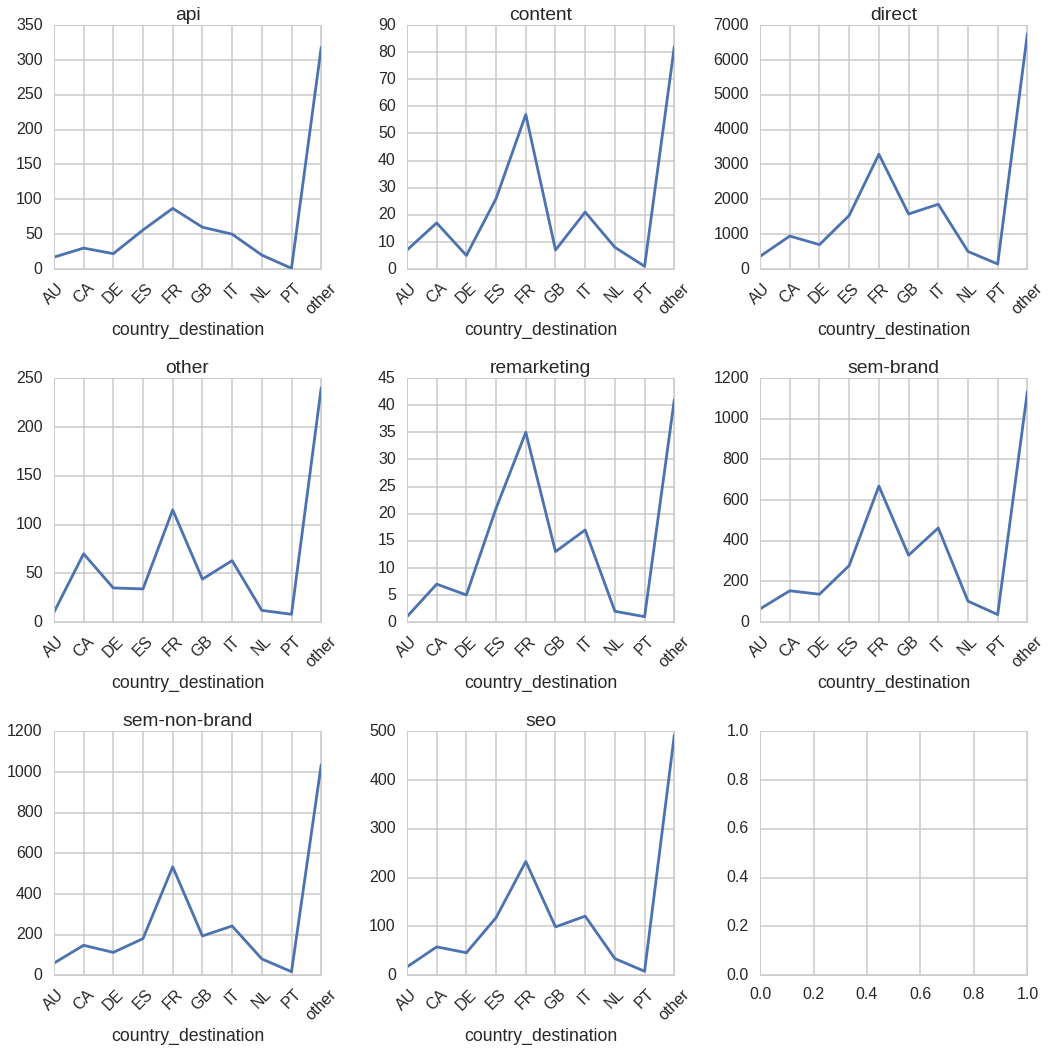

In [127]:
# exclude NDF and US
plot_crosstab_distribution(affiliate_channel_rel[affiliate_channel_rel.columns.drop(['NDF', 'US'])])

** Affliate Provider **

In [16]:
data.affiliate_provider.value_counts()

direct                 181270
google                  65956
other                   13036
facebook                 3996
bing                     3719
craigslist               3475
padmapper                 836
vast                      830
yahoo                     653
facebook-open-graph       566
gsp                       455
meetup                    358
email-marketing           270
naver                      66
baidu                      32
yandex                     18
wayn                        8
daum                        3
Name: affiliate_provider, dtype: int64

In [17]:
affliate_provider_relationship = pd.crosstab(data.iloc[:ntrain]['affiliate_provider'], target)

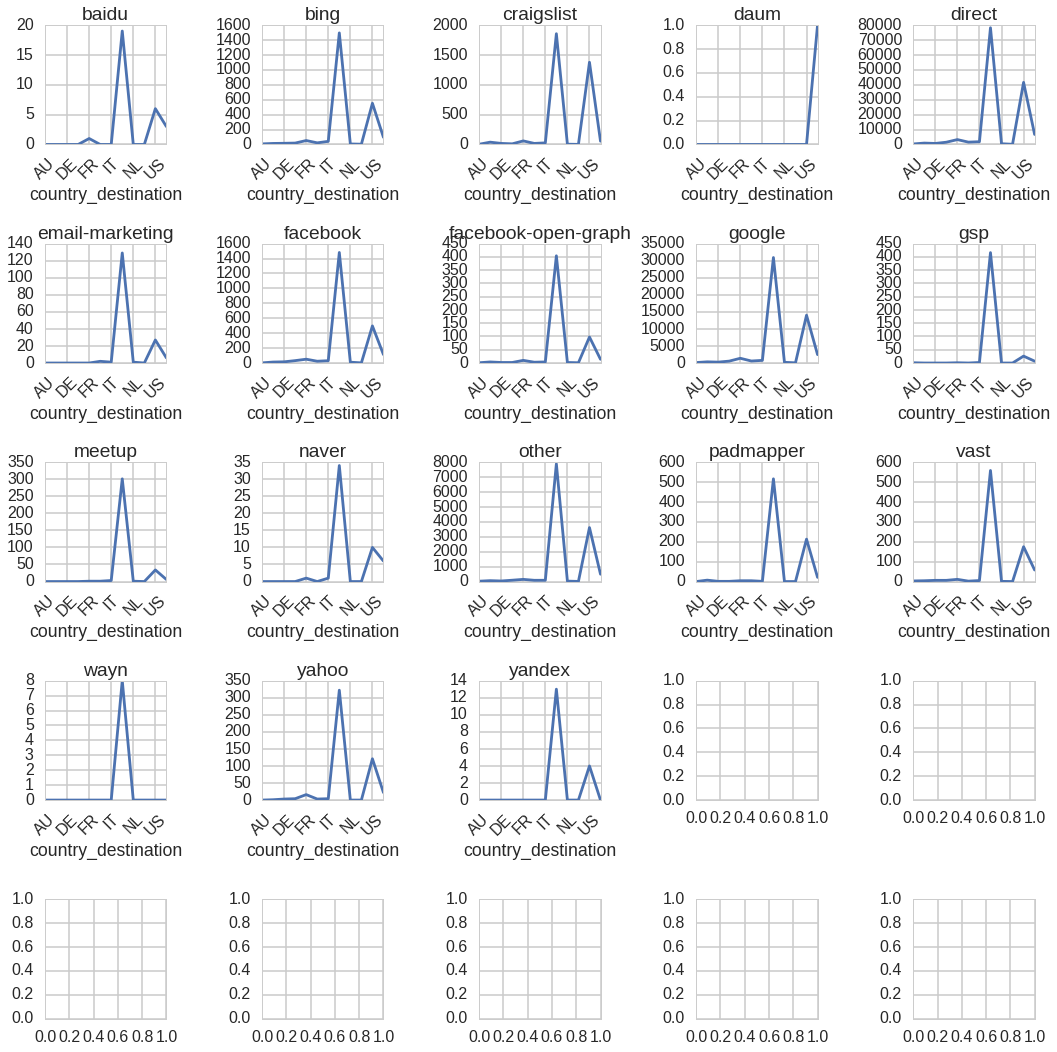

In [19]:
plot_crosstab_distribution(affliate_provider_relationship)

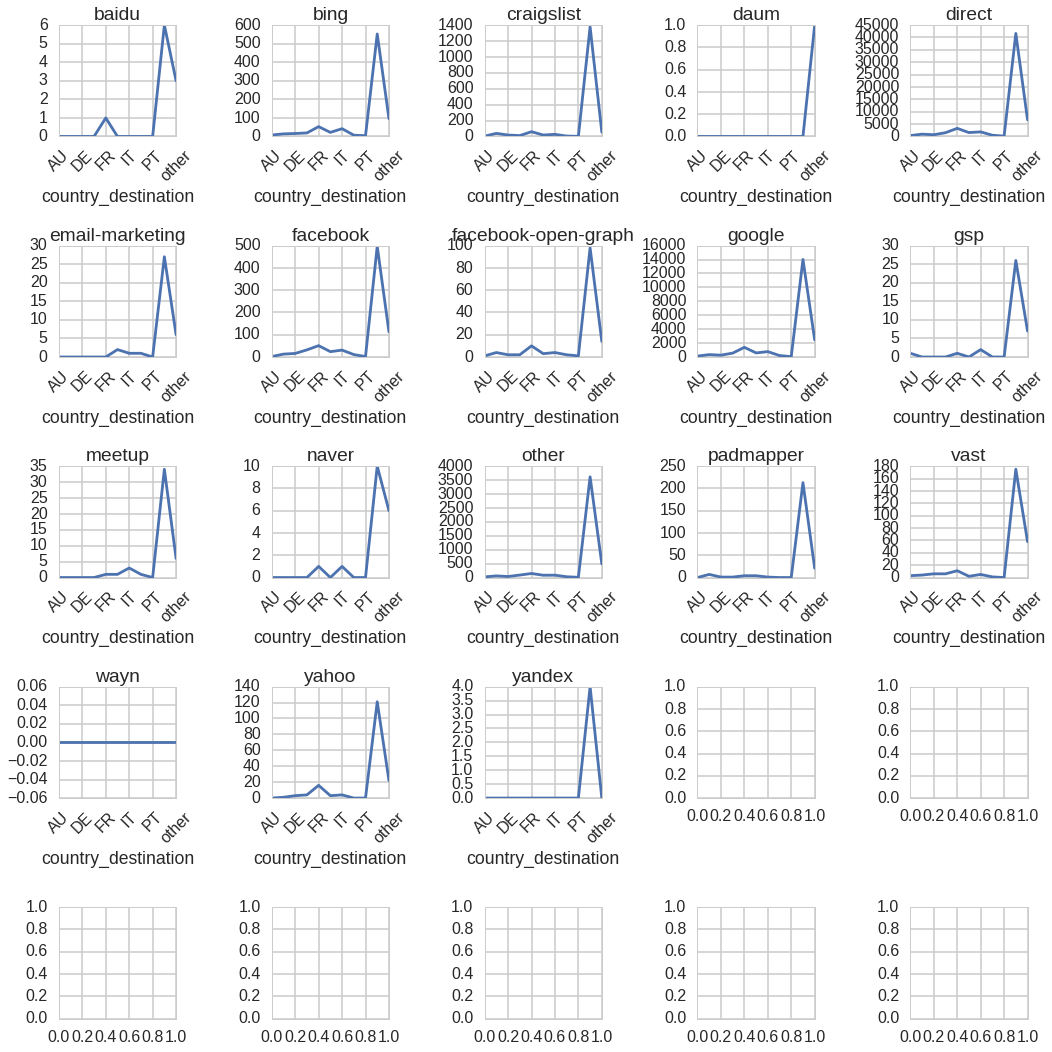

In [23]:
plot_crosstab_distribution(affliate_provider_relationship[affliate_provider_relationship.columns.drop('NDF')])

In [30]:
# Which of the providers overlap with each other in train and test set ?
train_providers = data.iloc[:ntrain].affiliate_provider
test_providers  = data.iloc[ntrain:].affiliate_provider

print(set(train_providers) & set(test_providers))

{'direct', 'yahoo', 'bing', 'padmapper', 'yandex', 'other', 'baidu', 'facebook-open-graph', 'facebook', 'craigslist', 'google', 'meetup', 'vast', 'naver', 'email-marketing', 'daum', 'gsp'}


In [31]:
# Which of the providers are only present in the training set  ?
print(set(train_providers) - set(test_providers))

{'wayn'}


In [32]:
# Which of the providers are only present in the test set ?
print(set(test_providers) - set(train_providers))

set()


** We can remove all rows which have _wayn_ as the affiliate provider in our training set. **

** Age of the user ( this contains missing value as well) **

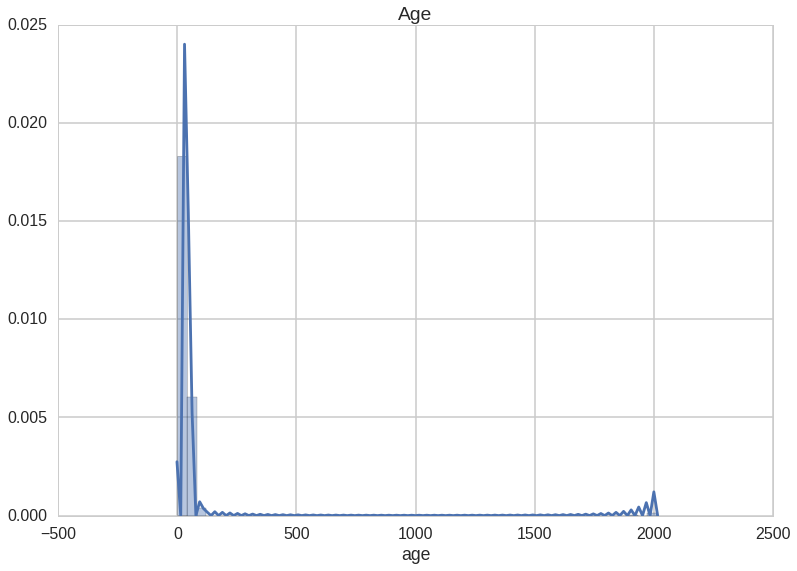

In [37]:
sns.distplot(data[data.age.notnull()].age)
plt.title('Age');

In [40]:
data.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [46]:
data.loc[data.age > 100, 'age'].value_counts()

105.0     1351
2014.0     710
110.0      228
104.0       52
101.0       40
102.0       39
2013.0      39
109.0       36
103.0       30
107.0       28
106.0       20
108.0       16
115.0       13
1927.0       6
1928.0       6
2001.0       5
113.0        4
1931.0       4
1935.0       3
1925.0       3
1933.0       3
1949.0       3
1924.0       3
1947.0       3
1934.0       3
1932.0       3
1938.0       2
1920.0       2
1929.0       2
1951.0       2
1926.0       2
1923.0       2
1940.0       2
1936.0       2
111.0        2
1944.0       2
1953.0       1
1954.0       1
112.0        1
2000.0       1
132.0        1
1968.0       1
1942.0       1
1930.0       1
1937.0       1
1995.0       1
1941.0       1
2002.0       1
1945.0       1
150.0        1
1922.0       1
1952.0       1
1948.0       1
2008.0       1
1939.0       1
Name: age, dtype: int64

** As we can see some people have mentioned their year of birth instead of actual age. So this would need some modifications. **

** Let's see if age has any effect on the country of first booking **

In [59]:
mask = np.logical_and(data.iloc[:ntrain].age.notnull(), data.iloc[:ntrain].age < 110)

In [61]:
ages       = data.iloc[:ntrain].loc[mask, 'age']
target_sub = target.iloc[ages.index.values]

In [64]:
ages_target = pd.concat((ages, target_sub), axis=1)

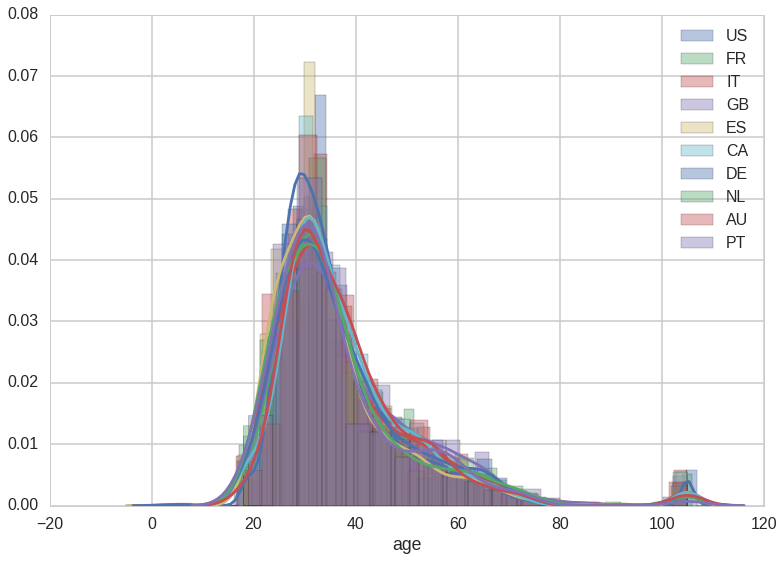

In [73]:
sns.distplot(ages_target[ages_target.country_destination == 'US'].age, label='US')
sns.distplot(ages_target[ages_target.country_destination == 'FR'].age, label='FR')
sns.distplot(ages_target[ages_target.country_destination == 'IT'].age, label='IT')
sns.distplot(ages_target[ages_target.country_destination == 'GB'].age, label='GB')
sns.distplot(ages_target[ages_target.country_destination == 'ES'].age, label='ES')
sns.distplot(ages_target[ages_target.country_destination == 'CA'].age, label='CA')
sns.distplot(ages_target[ages_target.country_destination == 'DE'].age, label='DE')
sns.distplot(ages_target[ages_target.country_destination == 'NL'].age, label='NL')
sns.distplot(ages_target[ages_target.country_destination == 'AU'].age, label='AU')
sns.distplot(ages_target[ages_target.country_destination == 'PT'].age, label='PT')
plt.legend(loc='best');

** Distribution looks more or less similiar for all the countries **

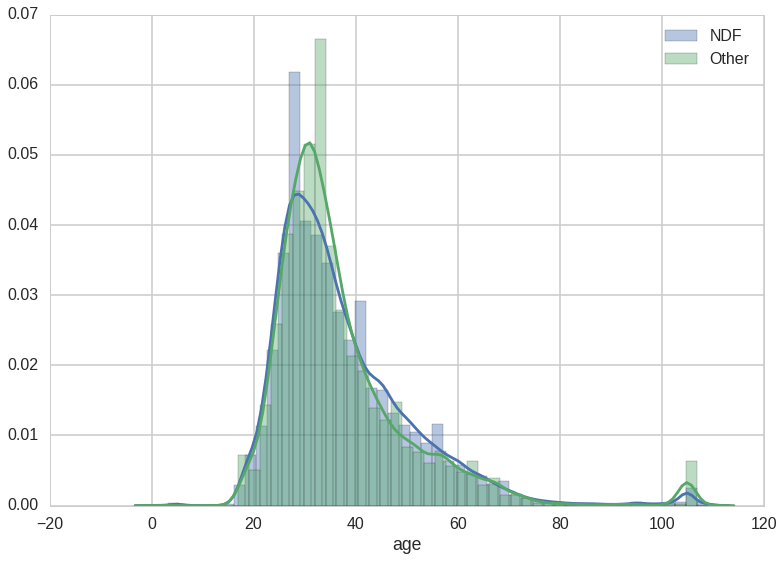

In [76]:
sns.distplot(ages_target[ages_target.country_destination == 'NDF'].age, label='NDF')
sns.distplot(ages_target[ages_target.country_destination == 'other'].age, label='Other')
plt.legend(loc='best');

In [81]:
# let's see if missing values are any source of indicator of destination country
missing_ages = data.iloc[:ntrain].loc[~mask, 'age']
target_sub   = target.iloc[missing_ages.index.values]
ages_target_missing = pd.concat((missing_ages, target_sub), axis=1)

In [86]:
ages_target_missing.country_destination.value_counts(normalize=True)

NDF      0.766202
US       0.158135
other    0.028892
FR       0.014957
IT       0.009147
GB       0.006304
ES       0.006203
CA       0.004012
DE       0.002439
NL       0.001854
AU       0.001180
PT       0.000674
Name: country_destination, dtype: float64

In [87]:
ages_target.country_destination.value_counts(normalize=True)

NDF      0.452830
US       0.388096
other    0.060443
FR       0.029663
IT       0.016238
GB       0.014165
ES       0.013634
CA       0.008605
DE       0.006781
NL       0.004797
AU       0.003487
PT       0.001261
Name: country_destination, dtype: float64

In [88]:
# missing values can be used as an indicator variable for country destination

** Date Account Created - The date of account creation **

In [90]:
data.date_account_created.min(), data.date_account_created.max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2014-09-30 00:00:00'))

In [92]:
print('Train: Min Date Account Created: %s and Max Date Account Created: %s '%\
      (data.iloc[:ntrain].date_account_created.min(), data.iloc[:ntrain].date_account_created.max()))

Train: Min Date Account Created: 2010-01-01 00:00:00 and Max Date Account Created: 2014-06-30 00:00:00 


In [93]:
print('Test: Min Date Account Created: %s and Max Date Account Created: %s '%\
      (data.iloc[ntrain:].date_account_created.min(), data.iloc[ntrain:].date_account_created.max()))

Test: Min Date Account Created: 2014-07-01 00:00:00 and Max Date Account Created: 2014-09-30 00:00:00 


In [94]:
# create month variable from data
month_account_created = data.iloc[:ntrain].date_account_created.dt.month

In [96]:
month_acc_created_target_rel = pd.crosstab(month_account_created, target)

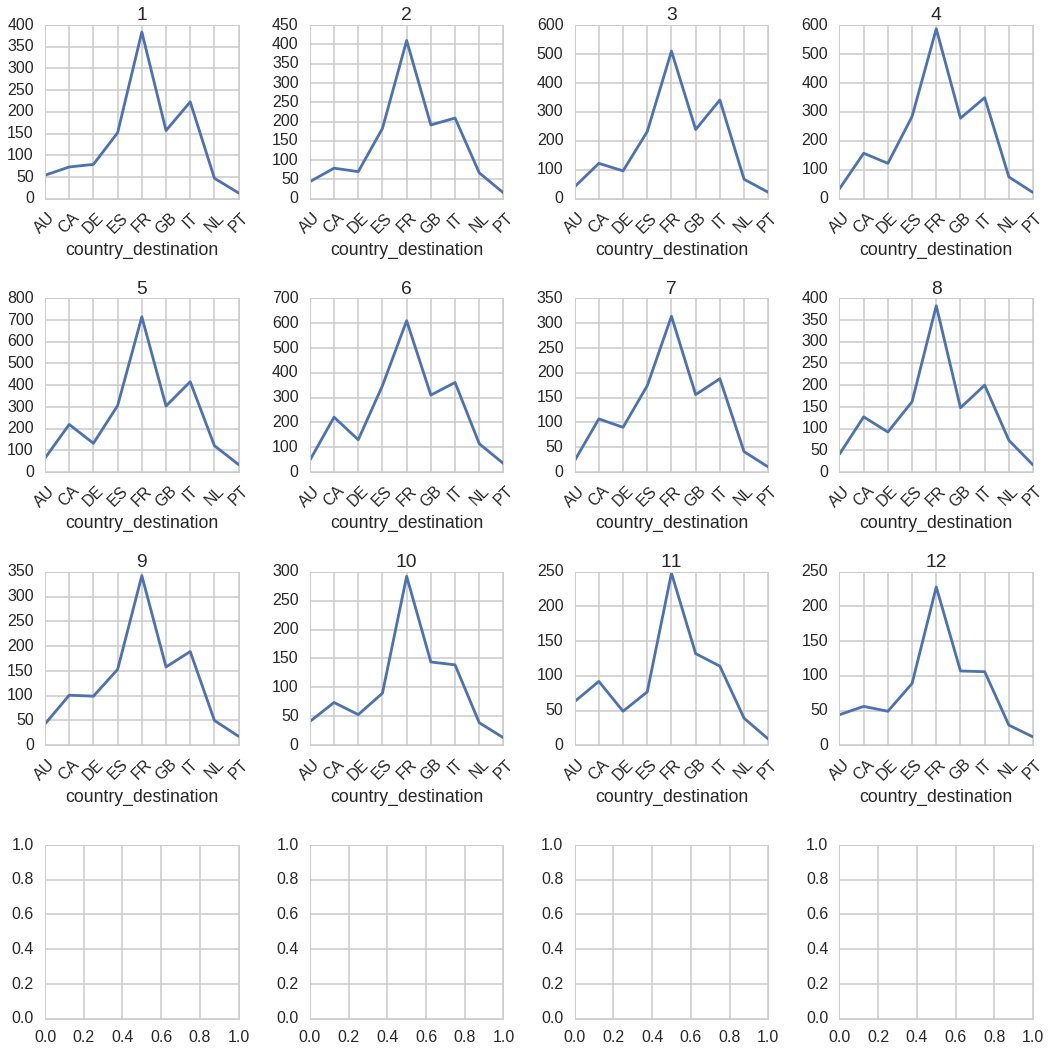

In [100]:
plot_crosstab_distribution(month_acc_created_target_rel[month_acc_created_target_rel.columns.drop(['NDF', 'US', 'other'])])

** date_first_booking: Date of First Booking **

** For users with no missing value for date of first booking we can safely predict as NDF **

In [109]:
mask = (data.iloc[:ntrain].date_first_booking.isnull())

target[mask].value_counts()

NDF    124543
Name: country_destination, dtype: int64